In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.ndimage import gaussian_filter1d
%config InlineBackend.figure_formats = ['svg']
from matplotlib.ticker import FuncFormatter

df = pd.read_csv('data/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()

# NON VOTING EQUIPMENT TO EXCLUDE/SEPARATE FROM ANALYSIS
non_voting_equipment = ['Paper Poll Book',
                        'Hand Counted Paper Ballots', 
                        'Commercial Electronic Poll Book',
                        'In-House Electronic Poll Book',
                        'Data Unavailable']

# EXCLUDE ELECTRONIC VOTING
exclude_remote = ['Internet Voting: Email',
                    'Internet Voting: Web Portal',
                    'Internet Voting: Fax',
                    'Remote Ballot Marking System: Client-Side',
                    'Remote Ballot Marking System: Server-Side']

# OTHER EQUIPMENT TYPES DEEMED ACCEPTABLE
voting_equipment_types = ['Ballot Marking Device', 
                            'Hand-Fed Optical Scanner',
                            'Batch-Fed Optical Scanner',
                            'DRE-Touchscreen',
                            'DRE-Push Button',
                            'DRE-Dial',
                            'Mechanical Lever Machine',
                            'Punch Card Voting System',
                            'Hybrid BMD/Tabulator',
                            'Hybrid Optical Scan/DRE',
                            'Hybrid Optical Scan/BMD']

# filter only for VVSG relevant equipment
df = df[df['Equipment Type'].isin(voting_equipment_types)]

# merge DRE categories
df.loc[df['Equipment Type'].str.startswith('DRE'), 'Equipment Type'] = 'DRE'


/var/folders/4t/gs7xjwb92bd6lfy7w82b3s4r0000gn/T/ipykernel_88737/1045051902.py:9: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()


# QR code analysis

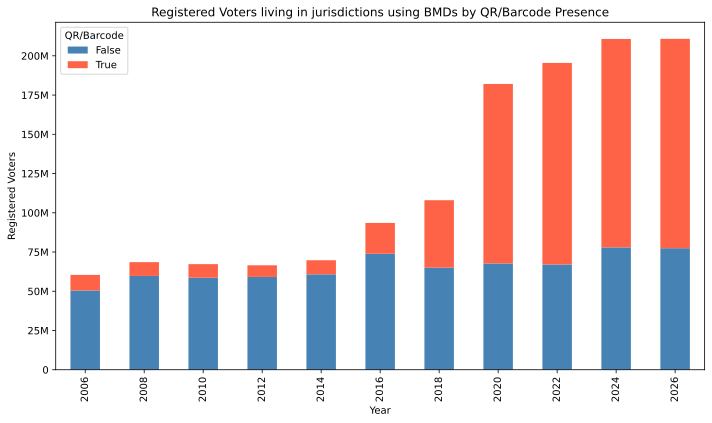

In [2]:
# Filter for Ballot Marking Devices
df_bmd = df[df['Equipment Type'].str.contains('Ballot Marking Device|BMD', case=False, na=False)]


# Group by Year and QR/Barcode, summing Registered Voters
grouped = df_bmd.groupby(['Year', 'QR/Barcode'])['Registered Voters'].sum().unstack(fill_value=0)

# Plot as stacked bar
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color={True: 'tomato', False: 'steelblue'})


# Format large numbers to "1.1M" style
def human_readable(x, pos):
    if x >= 1_000_000:
        return f'{x * 1e-6:.0f}M'
    elif x >= 1_000:
        return f'{x * 1e-3:.0f}K'
    else:
        return str(int(x))

ax.yaxis.set_major_formatter(FuncFormatter(human_readable))


plt.title('Registered Voters living in jurisdictions using BMDs by QR/Barcode Presence')
plt.xlabel('Year')
plt.ylabel('Registered Voters')
plt.legend(title='QR/Barcode')
plt.tight_layout()
plt.show()


/var/folders/4t/gs7xjwb92bd6lfy7w82b3s4r0000gn/T/ipykernel_88737/304183854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmd['Manufacturer Model'] = df_bmd['Manufacturer'] + ' ' + df_bmd['Model']


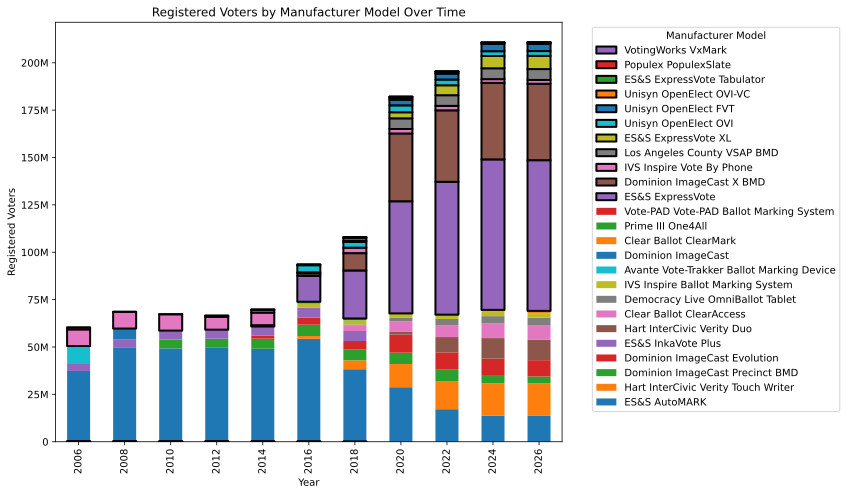

In [4]:
df_bmd['Manufacturer Model'] = df_bmd['Manufacturer'] + ' ' + df_bmd['Model']


# Group by Manufacturer Model and take the most common QR/Barcode value for each model
qr_code_dict = df_bmd.groupby('Manufacturer Model')['QR/Barcode'].agg(lambda x: x.mode()[0]).to_dict()


# Group by Year and Manufacturer Model, summing registered voters
grouped = df_bmd.groupby(['Year', 'Manufacturer Model'])['Registered Voters'].sum().unstack(fill_value=0)

# Optional: sort columns by total usage over all years (for legend readability)
grouped = grouped[grouped.sum().sort_values(ascending=False).index]

# Sort the columns based on QR/Barcode usage (True first, then False)
sorted_columns = sorted(grouped.columns, key=lambda x: qr_code_dict.get(x, False), reverse=False)
grouped = grouped[sorted_columns]

# Plot
ax = grouped.plot(kind='bar', stacked=True, figsize=(12, 7))


# Outline bars with QR/Barcode usage (True)
for i, year in enumerate(grouped.index):
    for j, manufacturer_model in enumerate(grouped.columns):
        if qr_code_dict.get(manufacturer_model, False):  # Check if model uses QR/Barcode
            # Get the height of the bar for that year and manufacturer model
            bar_height = grouped.iloc[i, j]
            # Outline that segment (QR code segment) by plotting over it
            ax.patches[j * len(grouped) + i].set_edgecolor('black')
            ax.patches[j * len(grouped) + i].set_linewidth(2)

ax.yaxis.set_major_formatter(FuncFormatter(human_readable))


plt.title('Registered Voters by Manufacturer Model Over Time')
plt.xlabel('Year')
plt.ylabel('Registered Voters')
plt.legend(title='Manufacturer Model', bbox_to_anchor=(1.05, 1), loc='upper left', reverse=True)
plt.tight_layout()
plt.show()

